# Extension Plan - Health Data Aquisition

Wildland fires create many challenges for communities near fire-prone areas, affecting
air quality, public health, safety, and the environment. In places like Stockton, CA, where
wildfires have become more common, the effects of smoke range from breathing
problems to mental health, the economy, and overall community well-being.

This project will specifically examine the health effects of wildfire smoke, particularly
concerning respiratory diseases and cancer. Understanding these impacts is crucial for
addressing health inequalities in the community. Exposure to wildfire smoke, especially
fine particulate matter (PM2.5), is linked to various respiratory illnesses such as asthma,
chronic obstructive pulmonary disease (COPD), and lung infections. Additionally, PM2.5
has been associated with increased risks of cancers, including lung cancer and certain
types of throat cancer. By analyzing health data in conjunction with the wildland fire
data, this study aims to provide useful information for public health officials and
community leaders in Stockton.

### Prelimineries

Lets start by installing and importing all the packages to load data

In [1]:
%%capture
%pip install matplotlib
%pip install statsmodels

In [2]:
# packages for data manipulation and plot generation
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

# packages for scaling and calculating correlation coefficients
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

### Retreiving Healthcare data

For the purpose of this analysis, I was interested in exploring the datasets made available by the below sources - 
1. **Multiple Causes of Death - CDC**: The Multiple Cause of Death database provides mortality and population
statistics for all U.S. counties, based on death certificates of U.S. residents. Each
certificate includes a primary cause of death, up to twenty additional contributing
causes, and demographic information.
2. **Healthcare Cost and Utilization Project - AHRC**: 
The Agency for Healthcare Research and Quality (AHRQ) is focused on
improving the quality, safety, efficiency, and accessibility of healthcare in the U.S.
It conducts research and provides resources aimed at enhancing healthcare
systems and outcomes, with special attention to patient safety, care
effectiveness, and reducing healthcare disparities. The Healthcare Cost and
Utilization Project (HCUP) is a comprehensive source of hospital data across the
U.S., providing insights into hospitalizations, healthcare utilization, and costs.
3. **California Health and Human Services**: The California Health and Human Services Agency (CalHHS) has launched its Open Data Portal initiative in order to increase public access to one of the State’s most valuable assets – non-confidential health and human services data. The portal offers access to standardized data that can be easily retrieved, searched, analyzed,  and re-used by individuals.This portal allows us to access information about hospital discharges.

*Note: The first 2 data sources were mentioned in my initial extension plan, and I found the third source more recently. Since CalHHS directly provides an aggregated information of the data in AHRC, I'll just use the CalHHS data for this analysis.*

##### Exploring the data from CDC

To support this analysis, I obtained health data for **San Joaquin County**, where the city of **Stockton** is located. The focus of this analysis is to understand the impact of wildfire smoke on residents' health, particularly in relation to diseases linked to exposure to fine particulate matter (PM2.5), a major component of wildfire smoke.

Using the CDC's data extraction tools, I downloaded datasets related to specific diagnoses that are strongly associated with PM2.5 exposure. The selected causes of death include both respiratory and cancer-related conditions, which provide a comprehensive perspective on health outcomes influenced by air quality.

Below is a list of the diagnosed cause of deaths I started my analysis with:

Respiratory Diseases
- Asthma
- Chronic Obstructive Pulmonary Disease (COPD)
- Pneumonia
- Bronchitis
- Upper Respiratory Infections

Cancer
- Lung Cancer
- Colorectal Cancer

To begin, let’s load the data into a dataframe for cleaning, processing, and subsequent analysis.

In [3]:
cdc_death_data = pd.read_csv("resources/CDC_1999_2020.txt", sep='\t')
cdc_death_data_pl = pl.from_dataframe(cdc_death_data)
cdc_death_data_pl

Notes,Year,Year Code,Multiple Cause of death,Multiple Cause of death Code,Deaths,Population,Crude Rate
str,f64,f64,str,str,i64,i64,str
null,1999.0,1999.0,"""Colon, unspecified - Malignant…","""C18.9""",81,552424,"""14.7"""
null,1999.0,1999.0,"""Bronchus or lung, unspecified …","""C34.9""",282,552424,"""51.0"""
null,1999.0,1999.0,"""Bronchopneumonia, unspecified""","""J18.0""",13,552424,"""Unreliable"""
null,1999.0,1999.0,"""Lobar pneumonia, unspecified""","""J18.1""",11,552424,"""Unreliable"""
null,1999.0,1999.0,"""Hypostatic pneumonia, unspecif…","""J18.2""",18,552424,"""Unreliable"""
…,…,…,…,…,…,…,…
null,2020.0,2020.0,"""Other specified chronic obstru…","""J44.8""",13,767967,"""Unreliable"""
null,2020.0,2020.0,"""Chronic obstructive pulmonary …","""J44.9""",610,767967,"""79.4"""
null,2020.0,2020.0,"""Asthma, unspecified""","""J45.9""",67,767967,"""8.7"""


A quick look at the data shows that there are a few rows with 'Notes' as Total. These seem to be some out of the box aggregations, but I'll be filtering them out to make sure all my rows are of the same structure. Im most interested in the year, cause of death and count, so I'll be selecting only those columns for the my analysis.

In [4]:
cdc_death_data_filtered = (
    cdc_death_data_pl
    .filter(
        pl.col("Notes").is_null()
    )
    .select([
        "Year",
        "Multiple Cause of death",
        "Deaths",
        "Population"
    ])
)
cdc_death_data_filtered

Year,Multiple Cause of death,Deaths,Population
f64,str,i64,i64
1999.0,"""Colon, unspecified - Malignant…",81,552424
1999.0,"""Bronchus or lung, unspecified …",282,552424
1999.0,"""Bronchopneumonia, unspecified""",13,552424
1999.0,"""Lobar pneumonia, unspecified""",11,552424
1999.0,"""Hypostatic pneumonia, unspecif…",18,552424
…,…,…,…
2020.0,"""Chronic obstructive pulmonary …",71,767967
2020.0,"""Chronic obstructive pulmonary …",27,767967
2020.0,"""Other specified chronic obstru…",13,767967


The data looks organized for me to proceed further. We see different values under the column "Mutliple Cause of death", with words like unspecified. Lets look at the unique values present in this particular column of the dataframe.

In [5]:
unique_causes = cdc_death_data_filtered["Multiple Cause of death"].unique()
for cause in unique_causes:
    print(cause)

Chronic obstructive pulmonary disease with acute exacerbation, unspecified
Chronic obstructive pulmonary disease with acute lower respiratory infection
Bronchus or lung, unspecified - Malignant neoplasms
Lobar pneumonia, unspecified
Other specified chronic obstructive pulmonary disease
Asthma, unspecified
Bronchopneumonia, unspecified
Pneumonia, unspecified
Chronic obstructive pulmonary disease, unspecified
Colon, unspecified - Malignant neoplasms
Hypostatic pneumonia, unspecified


Looking at this list, we notice that there are 3 causes that are related to COPD, and 4 causes that fall under the category Pneumonia. Lets try to group these diseases into broader categories - Respiratory diseases(COPD, Asthma, Pneumonia) and Cancers(Lung cancer, Colon cancer)

We will create a dictory to map the individual values to the broader category

In [6]:
disease_map = {
	"Chronic obstructive pulmonary disease with acute lower respiratory infection" : "COPD",
	"Bronchus or lung, unspecified - Malignant neoplasms" : "Lung cancer",
    "Colon, unspecified - Malignant neoplasms": "Colon cancer",
	"Chronic obstructive pulmonary disease, unspecified" : "COPD",
	"Asthma, unspecified" : "Asthma",
	"Pneumonia, unspecified" : "Pneumonia",
    "Lobar pneumonia, unspecified": "Pneumonia",
    "Hypostatic pneumonia, unspecified": "Pneumonia",
    "Bronchopneumonia, unspecified": "Pneumonia",
	"Chronic obstructive pulmonary disease with acute exacerbation, unspecified" : "COPD",
	"Other specified chronic obstructive pulmonary disease" : "COPD"
}

cdc_death_data_clean = (
    cdc_death_data_filtered
    .with_columns(
        pl.col('Multiple Cause of death').replace_strict(disease_map).alias("Cause of Death")
    )
)
cdc_death_data_clean

Year,Multiple Cause of death,Deaths,Population,Cause of Death
f64,str,i64,i64,str
1999.0,"""Colon, unspecified - Malignant…",81,552424,"""Colon cancer"""
1999.0,"""Bronchus or lung, unspecified …",282,552424,"""Lung cancer"""
1999.0,"""Bronchopneumonia, unspecified""",13,552424,"""Pneumonia"""
1999.0,"""Lobar pneumonia, unspecified""",11,552424,"""Pneumonia"""
1999.0,"""Hypostatic pneumonia, unspecif…",18,552424,"""Pneumonia"""
…,…,…,…,…
2020.0,"""Chronic obstructive pulmonary …",71,767967,"""COPD"""
2020.0,"""Chronic obstructive pulmonary …",27,767967,"""COPD"""
2020.0,"""Other specified chronic obstru…",13,767967,"""COPD"""


Lets aggregate the data using the broader cause, and calculate the total number of deaths for each of the diseases per year

In [7]:
cdc_death_data_agg = (
    cdc_death_data_clean
    .group_by(
        [
            "Year",
            "Cause of Death"
        ]
    )
    .agg(
        pl.sum("Deaths")
    )
    .with_columns(
        pl.col("Year").cast(pl.Int64).alias("Year")
    )
    .sort(
        by=["Year"]
    )
)

cdc_death_data_agg

Year,Cause of Death,Deaths
i64,str,i64
1999,"""Asthma""",23
1999,"""Lung cancer""",282
1999,"""Pneumonia""",522
1999,"""Colon cancer""",81
1999,"""COPD""",466
…,…,…
2020,"""Pneumonia""",470
2020,"""Colon cancer""",102
2020,"""Asthma""",67


For ease of data manipulations, lets pivot this data such that each row represents the year, and each column represents the diseases. The values in each cell will then represent the number of deaths in the corresponding year(row) and corresponding disease(column). I also created a few extra columns for further grouping of respiratory diseases and cancers, and the total number of deaths per year. 

In [8]:
pivoted_death_data = (
    cdc_death_data_agg
    .pivot(
        on = "Cause of Death",
        index = "Year",
        values = "Deaths" 
    )
    .with_columns(
        (pl.col("Asthma") + pl.col("COPD") + pl.col("Pneumonia")).alias("Respiratory Diseases"),
        (pl.col("Lung cancer") + pl.col("Colon cancer")).alias("Cancer")
    )
    .with_columns(
        (pl.col("Cancer") + pl.col("Respiratory Diseases")).alias("Total Deaths")
    )
)
pivoted_death_data

Year,Asthma,Lung cancer,Pneumonia,Colon cancer,COPD,Respiratory Diseases,Cancer,Total Deaths
i64,i64,i64,i64,i64,i64,i64,i64,i64
1999,23,282,522,81,466,1011,363,1374
2000,20,285,472,80,462,954,365,1319
2001,12,304,460,81,506,978,385,1363
2002,25,334,484,80,513,1022,414,1436
2003,17,291,514,68,526,1057,359,1416
…,…,…,…,…,…,…,…,…
2016,36,239,214,72,630,880,311,1191
2017,38,226,235,78,595,868,304,1172
2018,26,232,246,77,546,818,309,1127


The structure of the dataframe looks good, with each row representing the year, and each column representing a count of deaths.

Lets plot the different values to see how the total deaths changed over the years

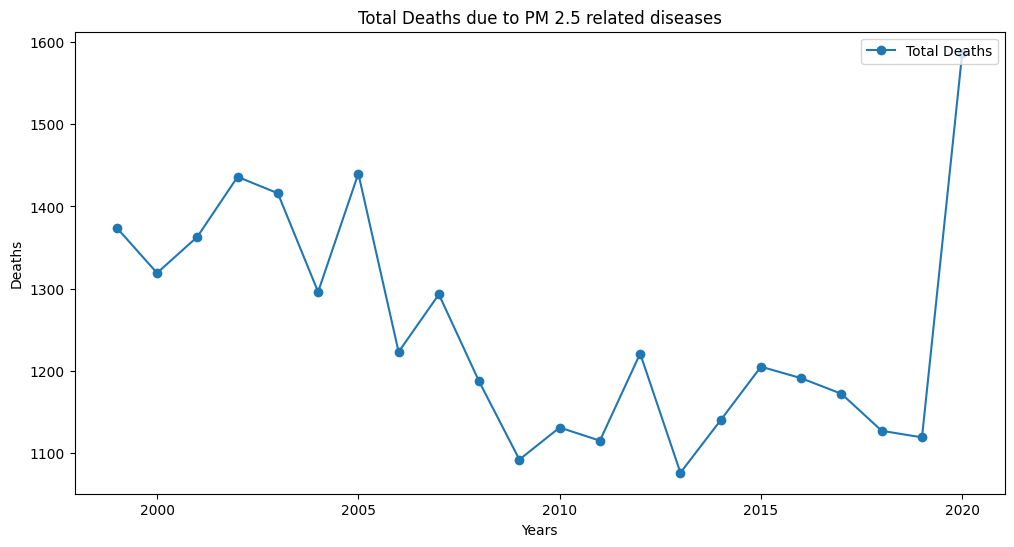

In [9]:
plt.figure(figsize=(12,6))

plt.plot(pivoted_death_data["Year"],pivoted_death_data["Total Deaths"] ,label = "Total Deaths", marker='o')

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Years')
plt.ylabel('Deaths')
plt.title('Total Deaths due to PM 2.5 related diseases')
plt.legend(loc="upper right")

plt.savefig("generated_plots/total_deaths_per_year.png", bbox_inches='tight') 

plt.show()

We notice a spike in the year 2020. This increase in deaths can be attributed to COVID, and might actually be only related to respiratory diseases and not cancers. To confirm this hypothesis, lets plot another graph to compare the deaths due to respiratory diseases and cancer

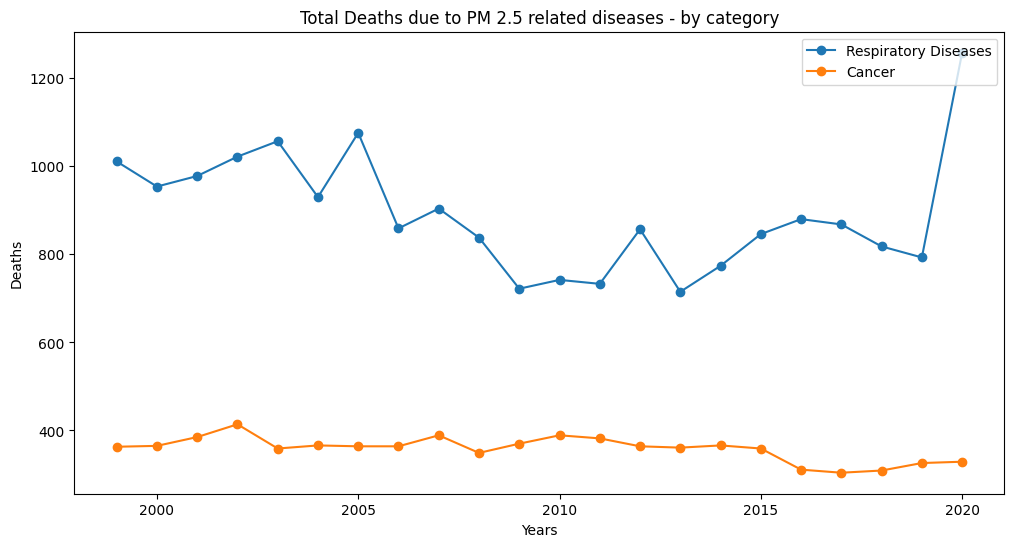

In [10]:
plt.figure(figsize=(12,6))

plt.plot(pivoted_death_data["Year"],pivoted_death_data["Respiratory Diseases"] ,label = "Respiratory Diseases", marker='o')
plt.plot(pivoted_death_data["Year"],pivoted_death_data["Cancer"] ,label = "Cancer", marker='o')

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Years')
plt.ylabel('Deaths')
plt.title('Total Deaths due to PM 2.5 related diseases - by category')
plt.legend(loc="upper right")

plt.savefig("generated_plots/categorical_deaths_per_year.png", bbox_inches='tight') 

plt.show()

Our hypothesis seems to be correct. Since we have a more granular level of data, i.e, deaths per disease, lets also plot a graph to compare deaths due to different causes

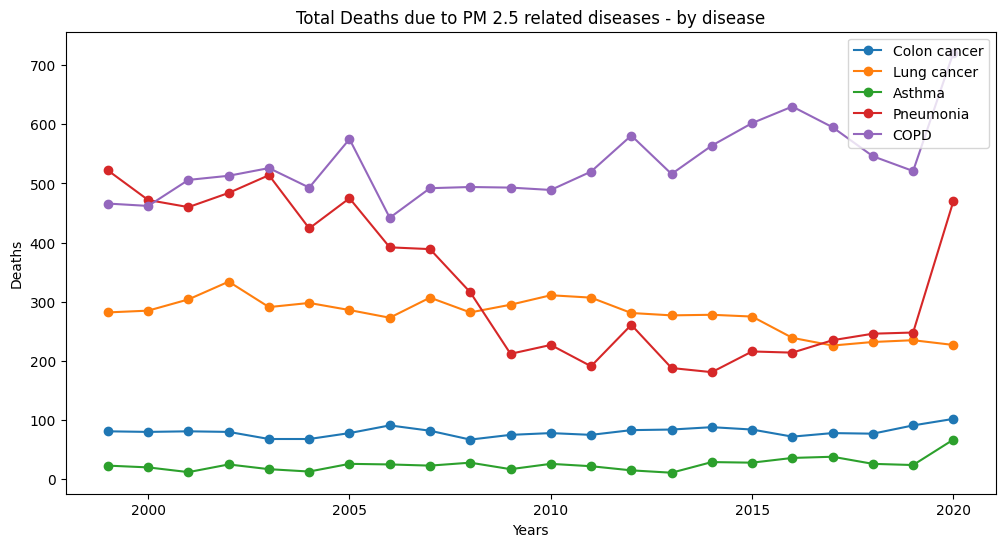

In [11]:
unique_causes = cdc_death_data_agg["Cause of Death"].unique()

plt.figure(figsize=(12,6))

for cause in unique_causes:
    plt.plot(pivoted_death_data["Year"],pivoted_death_data[cause] ,label = cause, marker='o')

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Years')
plt.ylabel('Deaths')
plt.title('Total Deaths due to PM 2.5 related diseases - by disease')
plt.legend(loc="upper right")

plt.savefig("generated_plots/deaths_per_disease_per_year.png", bbox_inches='tight') 

plt.show()

The graphs reveal several key trends:  

1. **Cancer vs. Respiratory Disease Mortality:** Deaths from cancer are notably lower than those from respiratory diseases, reflecting the acute nature of respiratory conditions.  

2. **COVID-19 Impact on Respiratory Diseases:** During the COVID-19 years, asthma-related deaths remained stable, possibly due to improved management or reduced exposure to triggers. However, deaths from COPD and pneumonia spiked sharply, likely driven by respiratory complications from COVID-19.  

3. **Consistency in Cancer Mortality:** Cancer-related deaths remained steady over the years, with no significant spikes or dips, reflecting the chronic nature of cancer compared to acute respiratory conditions.  

These trends highlight the varying impacts of public health crises and environmental factors on different health outcomes.

### Exploring the Data from CalHHS  

For this analysis, I decided to examine a **CalHHS dataset** providing annual hospital inpatient summary data by patient county of residence. This dataset includes detailed information on:  

- **Discharge Disposition:** Outcomes of hospital stays (e.g., home, transfer, death).  
- **Expected Payer:** Payment sources like Medicare, Medicaid, or private insurance.  
- **Demographics:** Patient sex and race, useful for analyzing health disparities.  
- **Diagnosis Classification:**  
  - **Major Diagnostic Categories (MDC):** Groups diagnoses into 25 exclusive categories for focused analysis.  
  - **MS-DRG:** Groups patients by clinical condition and resource usage.  
- **Admission Source and Type of Care:** Details on emergency vs. elective admissions and provided care types.  

To analyze the health impacts of wildfire smoke, I selected a table summarizing **annual hospital inpatient data by county**, focusing on MDC to isolate respiratory and related conditions.  

Next, we’ll load this dataset into a dataframe for further exploration and analysis.  

In [12]:
hospital_data_raw = pl.read_csv("resources/Hospital_inpatient_data_california.csv")
hospital_data_raw

_id,patcnty1,dsch_yr,mdc,mdc_desc,Discharges,AnnotationCode,AnnotationDesc
i64,str,i64,i64,str,i64,str,str
1,"""Alameda""",2012,1,"""NERVOUS SYSTEM, DISEASES & DIS…",7792,null,null
2,"""Alameda""",2012,2,"""EYE, DISEASES & DISORDERS""",195,null,null
3,"""Alameda""",2012,3,"""EAR, NOSE, MOUTH, & THROAT, DI…",1413,null,null
4,"""Alameda""",2012,4,"""RESPIRATORY SYSTEM, DISEASES &…",11569,null,null
5,"""Alameda""",2012,5,"""CIRCULATORY SYSTEM, DISEASES &…",15745,null,null
…,…,…,…,…,…,…,…
17772,"""Yuba""",2023,21,"""INJURIES, POISONINGS, AND TOXI…",121,null,null
17773,"""Yuba""",2023,22,"""BURNS""",12,null,null
17774,"""Yuba""",2023,23,"""FACTORS ON HEALTH STATUS & OTH…",51,null,null


Since we are only interested in the data related to Stockton, California, lets filter the data based on the city's county, i.e,  San Joaquin. Also, since we are interested in the impact of wildfire smokes, lets filter the data to concentrate on the MDC Category related to respiratory diseases

In [13]:
hospital_data_filtered = (
    hospital_data_raw
    .filter(
        pl.col("patcnty1") == "San Joaquin",
        pl.col("mdc_desc") == "RESPIRATORY SYSTEM, DISEASES & DISORDERS"
    )
    .rename({
        "dsch_yr":"Year",
    })
    .select([
        "Year",
        "Discharges"
    ])
)

hospital_data_filtered

Year,Discharges
i64,i64
2012,5660
2013,5534
2014,5374
2015,5727
2016,5089
…,…
2019,5175
2020,6024
2021,6226


To enhance our analysis, we’ll merge the dataset on annual death counts with the hospitalization data to create a unified view of health trends in **San Joaquin County**.  By doing this we -

- Combine mortality and hospitalization data to analyze their relationship and explore the health impacts of wildfire smoke.  
- Preserve all available data by using an **outer join** since the death data starts from **1999** and the hospitalization data from **2012**.  

Post merging, the dataset will include only death counts for years before 2012. From 2012 onward, both deaths and hospital discharges will be available, aligned by year.  

In [14]:
discharge_and_death_data = (
    pivoted_death_data
    .join(
        hospital_data_filtered,
        on = "Year",
        how ="full"
    )
)

discharge_and_death_data

Year,Asthma,Lung cancer,Pneumonia,Colon cancer,COPD,Respiratory Diseases,Cancer,Total Deaths,Year_right,Discharges
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
1999,23,282,522,81,466,1011,363,1374,null,null
2000,20,285,472,80,462,954,365,1319,null,null
2001,12,304,460,81,506,978,385,1363,null,null
2002,25,334,484,80,513,1022,414,1436,null,null
2003,17,291,514,68,526,1057,359,1416,null,null
…,…,…,…,…,…,…,…,…,…,…
2019,24,235,248,91,521,793,326,1119,2019,5175
2020,67,227,470,102,721,1258,329,1587,2020,6024
null,null,null,null,null,null,null,null,null,2022,5553


This dataframe combines data from two sources: **death data from the CDC** and **hospitalization data from CalHHS**. The death data covers the years **1999-2020**, while the hospitalization data is available from **2012-2020**. As a result, the overlapping period for both datasets is **2012-2020**.  

To compare respiratory deaths and hospitalizations during these common years, we’ll scale the values (since they are on different ranges) and then visualize the data through a plot.

In [15]:
# finding the data where both death and discharge data is present
discharge_and_death_data_common = (
    discharge_and_death_data
    .filter(
        pl.col("Year") == pl.col("Year_right")
    )
)

discharge_and_death_data_common


Year,Asthma,Lung cancer,Pneumonia,Colon cancer,COPD,Respiratory Diseases,Cancer,Total Deaths,Year_right,Discharges
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
2012,15,281,261,83,581,857,364,1221,2012,5660
2013,11,277,188,84,516,715,361,1076,2013,5534
2014,29,278,181,88,564,774,366,1140,2014,5374
2015,28,275,216,84,602,846,359,1205,2015,5727
2016,36,239,214,72,630,880,311,1191,2016,5089
2017,38,226,235,78,595,868,304,1172,2017,5490
2018,26,232,246,77,546,818,309,1127,2018,5262
2019,24,235,248,91,521,793,326,1119,2019,5175
2020,67,227,470,102,721,1258,329,1587,2020,6024


We’ll create a helper function to scale the values, as scaling will be required for multiple plots.

In [16]:
# scale values of interest
scaler = MinMaxScaler()

def scale_columns(df, cols_to_scale, suffix="_scaled"):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df.select(cols_to_scale).to_numpy())
    
    # Add scaled columns to the DataFrame
    for i, col in enumerate(cols_to_scale):
        df = df.with_columns(pl.Series(name=f"{col}{suffix}", values=scaled_data[:, i]))
    return df

# scale the values - deaths due to respiratory diseases, discharges due to respiratory diseases
discharge_and_death_data_common_scaled = scale_columns(discharge_and_death_data_common, ["Respiratory Diseases", "Discharges"])
discharge_and_death_data_common_scaled


Year,Asthma,Lung cancer,Pneumonia,Colon cancer,COPD,Respiratory Diseases,Cancer,Total Deaths,Year_right,Discharges,Respiratory Diseases_scaled,Discharges_scaled
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64
2012,15,281,261,83,581,857,364,1221,2012,5660,0.26151,0.610695
2013,11,277,188,84,516,715,361,1076,2013,5534,0.0,0.475936
2014,29,278,181,88,564,774,366,1140,2014,5374,0.108656,0.304813
2015,28,275,216,84,602,846,359,1205,2015,5727,0.241252,0.682353
2016,36,239,214,72,630,880,311,1191,2016,5089,0.303867,0.0
2017,38,226,235,78,595,868,304,1172,2017,5490,0.281768,0.428877
2018,26,232,246,77,546,818,309,1127,2018,5262,0.189687,0.185027
2019,24,235,248,91,521,793,326,1119,2019,5175,0.143646,0.091979
2020,67,227,470,102,721,1258,329,1587,2020,6024,1.0,1.0


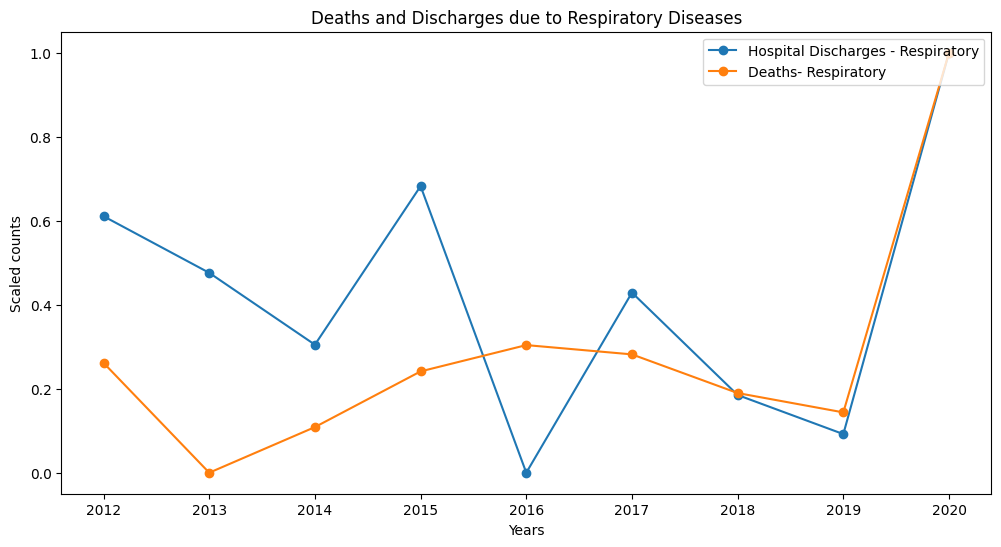

In [17]:
plt.figure(figsize=(12,6))

plt.plot(discharge_and_death_data_common_scaled["Year"], discharge_and_death_data_common_scaled["Discharges_scaled"] ,label = "Hospital Discharges - Respiratory", marker='o')
plt.plot(discharge_and_death_data_common_scaled["Year"], discharge_and_death_data_common_scaled["Respiratory Diseases_scaled"] ,label = "Deaths- Respiratory", marker='o')

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Years')
plt.ylabel('Scaled counts')
plt.title('Deaths and Discharges due to Respiratory Diseases')
plt.legend(loc="upper right")

plt.savefig("generated_plots/respiratory_discharges_and_deaths_per_year.png", bbox_inches='tight') 

plt.show()

The scaled graphs seem to be closely related, but lets make sure that the deaths and hospital discharges have a correlation. For this, we calculate the pearson coefficient using the function pearsonr from scipy.stats package.

In [18]:
correlation, p_value = pearsonr(discharge_and_death_data_common["Discharges"],discharge_and_death_data_common["Respiratory Diseases"])

print(f"Pearson correlation coefficient - deaths and discharges for respiratory diseases: {correlation}")

Pearson correlation coefficient - deaths and discharges for respiratory diseases: 0.6418247968413602


The correlation coefficient indicates a strong relationship between respiratory disease deaths and hospital discharges in **San Joaquin County** from **2012-2020**, suggesting that trends in both metrics are closely aligned.

### Next Steps  
We’ll now save the processed health data (deaths and hospital discharges) into a file for easy access to further explore correlations and build models to predict health outcomes based on wildfire smoke and other factors.

In [19]:
discharge_and_death_data.write_csv("generated_files/intermediate/discharge_and_death_data_1999_2020.csv")